<a href="https://colab.research.google.com/github/ArmandoSep/DS-Unit-2-Applied-Modeling/blob/master/module2-wrangle-ml-datasets/LS_DS_232.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets 
- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning

# Explore tabular data for superviesd machine learning 🍌

Wrangling your dataset is often the most challenging and time-consuming part of the modeling process.

In today's lesson, we’ll work with a dataset of [3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)!

Let’s get set up:

In [1]:
# Download data
import requests

def download(url):
    filename = url.split('/')[-1]
    print(f'Downloading {url}')
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)
    print(f'Downloaded {filename}')

download('https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz')

Downloaded instacart_online_grocery_shopping_2017_05_01.tar.gz


In [0]:
# Uncompress data
import tarfile
tarfile.open('instacart_online_grocery_shopping_2017_05_01.tar.gz').extractall()

In [3]:
# Change directory to where the data was uncompressed
%cd instacart_2017_05_01

/content/instacart_2017_05_01


In [4]:
# Print the csv filenames
from glob import glob
for filename in glob('*.csv'):
    print(filename)

aisles.csv
order_products__train.csv
departments.csv
order_products__prior.csv
products.csv
orders.csv


In [0]:
# For each csv file, look at its shape & head
import pandas as pd
from IPython.display import display

def preview(): 
  for filename in glob('*.csv'):
    df = pd.read_csv(filename)
    print('\n', filename, df.shape)
    display(df.head())


In [12]:
preview()


 aisles.csv (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation



 order_products__train.csv (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1



 departments.csv (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol



 order_products__prior.csv (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0



 products.csv (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13



 orders.csv (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### The original task was complex ...

[The Kaggle competition said,](https://www.kaggle.com/c/instacart-market-basket-analysis/data):

> The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order.

> orders.csv: This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders.

Each row in the submission is an order_id from the test set, followed by product_id(s) predicted to be reordered.

> sample_submission.csv: 
```
order_id,products
17,39276 29259
34,39276 29259
137,39276 29259
182,39276 29259
257,39276 29259
```

### ... but we can simplify!

Simplify the question, from "Which products will be reordered?" (Multi-class, [multi-label](https://en.wikipedia.org/wiki/Multi-label_classification) classification) to **"Will customers reorder this one product?"** (Binary classification)

Which product? How about **the most frequently ordered product?**


### Questions:

- What is the most frequently ordered product?
- How often is this product included in a customer's next order?
- Which customers have ordered this product before?
- How can we get a subset of data, just for these customers?
- What features can we engineer? We want to predict, will these customers reorder this product on their next order?

## Follow Along
### What was the most frequently ordered product?

In [13]:
order_products__train = pd.read_csv('order_products__train.csv')
order_products__train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [14]:
order_products__train['product_id'].value_counts()

24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
         ...  
44256        1
2764         1
4815         1
43736        1
46835        1
Name: product_id, Length: 39123, dtype: int64

In [20]:
# Group by example
temp = order_products__train.sort_values(by='product_id',
                                         ascending=False).head()
temp

,order_id,product_id,add_to_cart_order,reordered
891142,2198380,49688,10,0
1209047,2986153,49688,16,0
269349,655800,49688,10,1
1014644,2508423,49688,3,0
446055,1092104,49687,1,0


In [21]:
temp.groupby('product_id').count()

,order_id,add_to_cart_order,reordered
product_id,,,
49687,1,1,1
49688,4,4,4


In [22]:
order_products__train.groupby('product_id').order_id.count().sort_values(
    ascending=False
)

product_id
24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
         ...  
29560        1
8001         1
29566        1
8005         1
24836        1
Name: order_id, Length: 39123, dtype: int64

In [23]:
# Product 24852 was ordered almsot 20k times.
# Read the products table to see what product is it

products = pd.read_csv('products.csv')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [24]:
products[products.product_id==24852]

,product_id,product_name,aisle_id,department_id
24851,24852,Banana,24,4


In [0]:
# On -> the common column
train = pd.merge(order_products__train, products, how='inner', on='product_id')

In [26]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,816049,49302,7,1,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,Bulgarian Yogurt,120,16


In [27]:
train['product_name'].value_counts()

Banana                               18726
Bag of Organic Bananas               15480
Organic Strawberries                 10894
Organic Baby Spinach                  9784
Large Lemon                           8135
                                     ...  
Woman's Energy Tea                       1
Spearmint Xylitol Sweetened  Gum         1
Ultimate Flora Adult 15 Billion          1
Creole Seasoning                         1
Sesame Tamari Organic Vinaigrette        1
Name: product_name, Length: 39123, dtype: int64

### How often are bananas included in a customer's next order?

There are [three sets of data](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b):

> "prior": orders prior to that users most recent order (3.2m orders)  
"train": training data supplied to participants (131k orders)  
"test": test data reserved for machine learning competitions (75k orders)

Customers' next orders are in the "train" and "test" sets. (The "prior" set has the orders prior to the most recent orders.)

We can't use the "test" set here, because we don't have its labels (only Kaggle & Instacart have them), so we don't know what products were bought in the "test" set orders.

So, we'll use the "train" set. It currently has one row per product_id and multiple rows per order_id.

But we don't want that. Instead we want one row per order_id, with a binary column: "Did the order include bananas?"

Let's wrangle!

In [28]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,816049,49302,7,1,Bulgarian Yogurt,120,16
2,1242203,49302,1,1,Bulgarian Yogurt,120,16
3,1383349,49302,11,1,Bulgarian Yogurt,120,16
4,1787378,49302,8,0,Bulgarian Yogurt,120,16


In [0]:
# Goal: 'Yes, they orderer no bananas'.

train['bananas'] = train['product_name'] == 'Banana'

In [30]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
0,1,49302,1,1,Bulgarian Yogurt,120,16,False
1,816049,49302,7,1,Bulgarian Yogurt,120,16,False
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,False
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,False
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,False


In [36]:
# How ofen are banans included in the customer's next order? Is this true

train['bananas'].value_counts(normalize=True)

False    0.986476
True     0.013524
Name: bananas, dtype: float64

In [34]:
# Let's use group by to simply our data down to bananas only
# .any() -> if there is at least one True boolean, it will return True

train_wrangled = train.groupby('order_id')['bananas'].any().reset_index()
train_wrangled.head()

,order_id,bananas
0,1,False
1,36,False
2,38,False
3,96,False
4,98,False


In [35]:
train_wrangled['bananas'].value_counts(normalize=True)

False    0.857281
True     0.142719
Name: bananas, dtype: float64

In [37]:
# What is the most common hour of the day that bananas are ordered?
# What about the common hour for any order?

import numpy as np

train[train['bananas']]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
129688,226,24852,2,0,Banana,24,4,True
129689,473,24852,2,0,Banana,24,4,True
129690,878,24852,2,1,Banana,24,4,True
129691,1042,24852,1,1,Banana,24,4,True
129692,1139,24852,1,1,Banana,24,4,True
...,...,...,...,...,...,...,...,...
148409,3419531,24852,2,1,Banana,24,4,True
148410,3419542,24852,6,0,Banana,24,4,True
148411,3419629,24852,5,1,Banana,24,4,True
148412,3420088,24852,9,1,Banana,24,4,True


In [38]:
# What other table do we need? Orders:

orders = pd.read_csv('orders.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [39]:
# What hour of the day most typical to place an order?

orders['order_hour_of_day'].value_counts(normalize=True)

10    0.084306
11    0.083227
15    0.082909
14    0.082735
13    0.081261
12    0.079753
16    0.079669
9     0.075360
17    0.066878
18    0.053466
8     0.052089
19    0.041089
20    0.030485
7     0.026853
21    0.022832
22    0.017967
23    0.011705
6     0.008924
0     0.006652
1     0.003624
5     0.002797
2     0.002204
4     0.001616
3     0.001600
Name: order_hour_of_day, dtype: float64

# Join relational data for supervised machine learning

## Overview
Often, you’ll need to join data from multiple relational tables before you’re ready to fit your models.

### Which customers have ordered this product before?

- Customers are identified by `user_id`
- Products are identified by `product_id`

Do we have a table with both these id's? (If not, how can we combine this information?)

In [40]:
banana_order_id = train[train['bananas']].order_id
banana_order_id

129688        226
129689        473
129690        878
129691       1042
129692       1139
           ...   
148409    3419531
148410    3419542
148411    3419629
148412    3420088
148413    3420996
Name: order_id, Length: 18726, dtype: int64

In [43]:
orders[orders['order_id'].isin(banana_order_id)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
25,1492625,2,train,15,1,11,30.0
485,698604,34,train,6,4,13,30.0
623,1864787,43,train,12,5,11,26.0
652,1947848,46,train,20,4,20,11.0
881,13318,56,train,13,1,9,6.0
...,...,...,...,...,...,...,...
3420581,681092,206181,train,15,1,13,30.0
3420692,2530125,206191,train,6,0,9,30.0
3420786,3383615,206196,train,5,0,15,30.0
3420933,1716008,206205,train,4,1,16,10.0


In [44]:
# Most typical hour for people who bought bananas
banana_orders = orders[orders['order_id'].isin(banana_order_id)]
banana_orders['order_hour_of_day'].value_counts(normalize=True)


14    0.083467
15    0.081117
10    0.080263
11    0.078821
16    0.078340
12    0.077860
13    0.077593
9     0.073267
17    0.070383
18    0.061038
8     0.054737
19    0.044003
20    0.029745
7     0.028463
21    0.024405
22    0.019171
23    0.011481
6     0.008811
0     0.005340
1     0.003685
5     0.002830
2     0.002510
4     0.001442
3     0.001228
Name: order_hour_of_day, dtype: float64

In [45]:
banana_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
25,1492625,2,train,15,1,11,30.0
485,698604,34,train,6,4,13,30.0
623,1864787,43,train,12,5,11,26.0
652,1947848,46,train,20,4,20,11.0
881,13318,56,train,13,1,9,6.0


In [46]:
# Double check that we did things right, and that order 1492625 has a banana

train[train['order_id'] == 1492625]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
40632,1492625,11913,28,0,Shelled Pistachios,117,19,False
137883,1492625,24852,8,1,Banana,24,4,True
199519,1492625,9387,10,0,Granny Smith Apples,24,4,False
202785,1492625,45066,9,1,Honeycrisp Apple,24,4,False
241750,1492625,5450,11,1,Small Hass Avocado,24,4,False
269520,1492625,33957,21,1,Mexican Casserole Bowl,38,1,False
286130,1492625,41787,5,1,Bartlett Pears,24,4,False
356655,1492625,22963,1,1,Organic Roasted Turkey Breast,96,20,False
503295,1492625,48523,25,0,Birthday Cake Light Ice Cream,37,1,False
523860,1492625,38547,13,0,Bubblegum Flavor Natural Chewing Gum,46,19,False


## Follow Along

### How can we get a subset of data, just for these customers?

We want *all* the orders from customers who have *ever* bought bananas.

(And *none* of the orders from customers who have *never* bought bananas.)

In [0]:
# We did this above,
# note that this wasn't a merget directly
# but instead reused past merges and sliced a df by id

### What features can we engineer? We want to predict, will these customers reorder bananas on their next order?

In [47]:
# Is there a differece in average order size in bana orders vs. not?
# We know that it's about -10 items/order in general
# Number of items/order could be an interesting feature

orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [48]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
0,1,49302,1,1,Bulgarian Yogurt,120,16,False
1,816049,49302,7,1,Bulgarian Yogurt,120,16,False
2,1242203,49302,1,1,Bulgarian Yogurt,120,16,False
3,1383349,49302,11,1,Bulgarian Yogurt,120,16,False
4,1787378,49302,8,0,Bulgarian Yogurt,120,16,False


In [49]:
product_order_counts = train.groupby(['order_id']).count()['product_id']
product_order_counts

order_id
1           8
36          8
38          9
96          7
98         49
           ..
3421049     6
3421056     5
3421058     8
3421063     4
3421070     3
Name: product_id, Length: 131209, dtype: int64

In [50]:
product_order_counts.describe()

count    131209.000000
mean         10.552759
std           7.932847
min           1.000000
25%           5.000000
50%           9.000000
75%          14.000000
max          80.000000
Name: product_id, dtype: float64

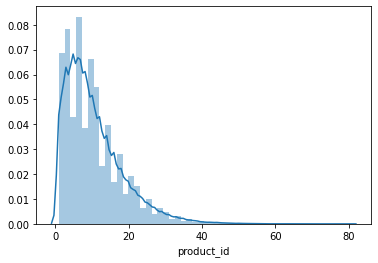

In [52]:
import seaborn as sns

sns.distplot(product_order_counts);

In [61]:
# Number of items in an order where bananas where purchased
banana_orders_counts = train[train['order_id'].isin(banana_order_id)].groupby(
    ['order_id']).count()['product_id']
banana_orders_counts.mean()

14.977517889565311

In [62]:
banana_orders_counts.describe()

count    18726.000000
mean        14.977518
std          8.491836
min          1.000000
25%          9.000000
50%         13.000000
75%         19.000000
max         80.000000
Name: product_id, dtype: float64

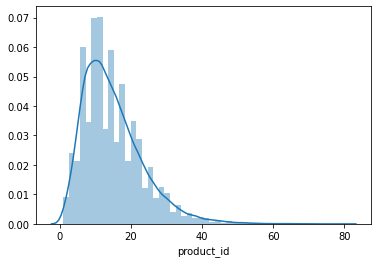

In [63]:
sns.distplot(banana_orders_counts);

## Challenge

**Continue to clean and explore your data.** Can you **engineer features** to help predict your target? For the evaluation metric you chose, what score would you get just by guessing? Can you **make a fast, first model** that beats guessing?

We recommend that you use your portfolio project dataset for all assignments this sprint. But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset today. Follow the instructions in the assignment notebook. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!